In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Source:
Link: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand

In [29]:
data = pd.read_csv("drive/My Drive/colab notebooks/SeoulBikeData.csv", encoding = 'unicode_escape')

In [30]:
data

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


# Narration:
- Features
- Target: Rented Bike Count

Needs to handle categorical columns. 

# EDA

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [32]:
# check missing value
data.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [33]:
data.corr()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
Rented Bike Count,1.000000,0.410257,0.538558,-0.199780,0.121108,0.199280,0.379788,0.261837,-0.123074,-0.141804
Hour,0.410257,1.000000,0.124114,-0.241644,0.285197,0.098753,0.003054,0.145131,0.008715,-0.021516
Temperature(°C),0.538558,0.124114,1.000000,0.159371,-0.036252,0.034794,0.912798,0.353505,0.050282,-0.218405
Humidity(%),-0.199780,-0.241644,0.159371,1.000000,-0.336683,-0.543090,0.536894,-0.461919,0.236397,0.108183
Wind speed (m/s),0.121108,0.285197,-0.036252,-0.336683,1.000000,0.171507,-0.176486,0.332274,-0.019674,-0.003554
Visibility (10m),0.199280,0.098753,0.034794,-0.543090,0.171507,1.000000,-0.176630,0.149738,-0.167629,-0.121695
Dew point temperature(°C),0.379788,0.003054,0.912798,0.536894,-0.176486,-0.176630,1.000000,0.094381,0.125597,-0.150887
Solar Radiation (MJ/m2),0.261837,0.145131,0.353505,-0.461919,0.332274,0.149738,0.094381,1.000000,-0.074290,-0.072301
Rainfall(mm),-0.123074,0.008715,0.050282,0.236397,-0.019674,-0.167629,0.125597,-0.074290,1.000000,0.008500
Snowfall (cm),-0.141804,-0.021516,-0.218405,0.108183,-0.003554,-0.121695,-0.150887,-0.072301,0.008500,1.000000


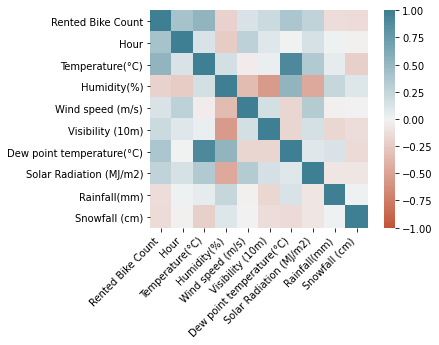

In [34]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [35]:
print(data['Seasons'].value_counts())
print("-----------------------------")
print(data['Holiday'].unique())
print("------------------------------")
print(data['Functioning Day'].unique())

Summer    2208
Spring    2208
Autumn    2184
Winter    2160
Name: Seasons, dtype: int64
-----------------------------
['No Holiday' 'Holiday']
------------------------------
['Yes' 'No']


## Narrative:
- 3 categorical columns.
- 2 needs to be binary encoded and 1 needs to be One hot encoded.

# Data preprocessing

- Needs to use datetime object to extract features from the "Date" column.

- I will only use "Day and month" so this model can be serialized in any future predictions. Keeping year in the feature won't help the model by any means.

- will rename all the columns to lower case and in an organized way so it will be easy to use the model in deployment.



### I will use "Sklearn's Individual models and Pipeline" and "PyCaret" to perform the prediction that is mainly a "Regression Task".

# Using Pipeline

In [55]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score

In [39]:
def preprocess_inputs(df):
  df = df.copy()

  #extract month and day from the Date column using datetime object
  df['Date'] = pd.to_datetime(df['Date'])
  df['month'] = df['Date'].apply(lambda x:x.month)
  df['day'] = df['Date'].apply(lambda x:x.day)

  #drop Date column
  df = df.drop("Date", axis=1)

  #rename the columns
  df.rename(columns={
      "Rented Bike Count": "rented_bike_count",
      "Hour": "hour",
      "Temperature(°C)": "temperature",
      "Humidity(%)": "humidity",
      "Wind speed (m/s)": "wind_speed",
      "Visibility (10m)": "visibility",
      "Dew point temperature(°C)": "dew_point_temperature",
      "Solar Radiation (MJ/m2)": "solar_radiation",
      "Rainfall(mm)": "rainfall",
      "Snowfall (cm)": "snowfall",
      "Seasons": "seasons",
      "Holiday": "holiday",
      "Functioning Day": "functioning_day"
  }, inplace=True)

  #performing binary encoding
  df['holiday'] = df['holiday'].apply(lambda x:1 if x == "Holiday" else 0)
  df['functioning_day'] = df['functioning_day'].apply(lambda x:1 if x == "Yes" else 0)

  #X and y
  X = df.drop("rented_bike_count", axis=1)
  y = df['rented_bike_count']

  #split
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, shuffle=True, random_state=21)

  return X_train, X_test, y_train, y_test

## Tree based models don't require scaled data so I am not using any "Standard Scaler" to scale the data.
i.e giving mean of 0 and variance of 1 to all the columns.

In [40]:
 X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [41]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

6132
2628
6132
2628


In [42]:
X_train

,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day,month,day
3792,0,16.4,72,0.8,1046,11.3,0.00,0.0,0.0,Spring,0,1,8,5
1179,3,-0.6,43,1.7,1316,-11.6,0.00,0.0,0.0,Winter,0,1,1,19
5393,17,30.1,65,1.8,1923,22.7,1.36,0.0,0.0,Summer,0,1,7,13
824,8,-8.6,55,0.6,1984,-16.0,0.00,0.0,0.0,Winter,0,1,4,1
6778,10,22.9,45,1.5,2000,10.3,2.10,0.0,0.0,Autumn,0,1,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,0,-4.7,52,1.8,1611,-13.0,0.00,0.0,0.0,Winter,0,1,5,1
6844,4,18.0,59,1.5,2000,9.8,0.00,0.0,0.0,Autumn,0,1,12,9
48,0,4.0,58,1.4,1296,-3.5,0.00,0.0,0.0,Winter,0,1,3,12
5944,16,33.6,57,3.5,1901,23.8,2.19,0.0,0.0,Summer,0,1,5,8


In [43]:
y_train

3792     712
1179      93
5393    1782
824      646
6778     928
        ... 
840      202
6844     215
48       342
5944     818
5327     373
Name: rented_bike_count, Length: 6132, dtype: int64

## Build the PIPELINE

In [44]:
nominal_transformer = Pipeline(steps=[
                          ('onehot', OneHotEncoder(sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
                                               ("nominal", nominal_transformer, ['seasons'])
], remainder = 'passthrough')

model = Pipeline(steps=[
                        ("preprocessor", preprocessor),
                        ("regressor", GradientBoostingRegressor())
])

In [63]:
#estimator = model.fit(X_train, np.ravel(y_train))
estimator = model.fit(X_train, y_train)

The numpy module of Python provides a function called numpy. ravel, which is used to change a 2-dimensional array or a multi-dimensional array into a contiguous flattened array. The returned array has the same data type as the source array or input array.

# Evaluation

In [52]:
#score = estimator.score(X_test, y_test)
#print("Score:", np.round(score*100), "%")

In [59]:
y_true = np.array(y_test)
print(y_true)

[ 395 1375  453 ... 2070 1507 1563]


In [60]:
y_pred = estimator.predict(X_test)
y_pred

array([ 438.68458802, 1483.12247896,  448.89799385, ..., 1580.45829765,
       1063.50487678, 1567.10104751])

In [61]:
#calculating the model's r-square
print("Model R^2 Score: {:.4f}".format(r2_score(y_true, y_pred)))

Model R^2 Score: 0.8488


In [62]:
#calculating MSE & RMSE
print(np.mean((y_test - y_pred) ** 2))

rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("RMSE is:", rmse)

64002.575240610124
RMSE is: 252.98730252842753


## Using PyCaret

In [64]:
!pip install pycaret

In [65]:
import pycaret.regression as pyr

In [66]:
def data_preparation(df):
  df = df.copy()

  #extract month and day from the Date column using datetime object
  df['Date'] = pd.to_datetime(df['Date'])
  df['month'] = df['Date'].apply(lambda x:x.month)
  df['day'] = df['Date'].apply(lambda x:x.day)

  #drop Date column
  df = df.drop("Date", axis=1)

  #rename the columns
  df.rename(columns={
      "Rented Bike Count": "rented_bike_count",
      "Hour": "hour",
      "Temperature(°C)": "temperature",
      "Humidity(%)": "humidity",
      "Wind speed (m/s)": "wind_speed",
      "Visibility (10m)": "visibility",
      "Dew point temperature(°C)": "dew_point_temperature",
      "Solar Radiation (MJ/m2)": "solar_radiation",
      "Rainfall(mm)": "rainfall",
      "Snowfall (cm)": "snowfall",
      "Seasons": "seasons",
      "Holiday": "holiday",
      "Functioning Day": "functioning_day"
  }, inplace=True)

  #performing binary encoding
  df['holiday'] = df['holiday'].apply(lambda x:1 if x == "Holiday" else 0)
  df['functioning_day'] = df['functioning_day'].apply(lambda x:1 if x == "Yes" else 0)


  return df

In [67]:
X = data_preparation(data)

In [68]:
X

,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day,month,day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,1,1,12
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,1,1,12
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,1,1,12
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,1,1,12
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,1,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,0,1,11,30
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,0,1,11,30
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,0,1,11,30
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,0,1,11,30


In [69]:
pyr.setup(
    data = X,
    target = 'rented_bike_count',
    train_size = 0.7,
    normalize = True
)

,Description,Value
0,session_id,4358
1,Target,rented_bike_count
2,Original Data,"(8760, 15)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6131, 28)"


(          hour  temperature  humidity  ...  month_7  month_8  month_9
 0    -1.652898    -1.507360 -1.039513  ...      0.0      0.0      0.0
 1    -1.509171    -1.532374 -0.990305  ...      0.0      0.0      0.0
 2    -1.365444    -1.574065 -0.941097  ...      0.0      0.0      0.0
 3    -1.221717    -1.590742 -0.891889  ...      0.0      0.0      0.0
 4    -1.077989    -1.574065 -1.088720  ...      0.0      0.0      0.0
 ...        ...          ...       ...  ...      ...      ...      ...
 8755  1.077919    -0.723572 -1.187136  ...      0.0      0.0      0.0
 8756  1.221646    -0.790277 -1.039513  ...      0.0      0.0      0.0
 8757  1.365373    -0.856982 -0.941097  ...      0.0      0.0      0.0
 8758  1.509101    -0.898673 -0.842681  ...      0.0      0.0      0.0
 8759  1.652828    -0.915349 -0.744266  ...      0.0      0.0      0.0
 
 [8760 rows x 28 columns],
 {'ada': <pycaret.containers.models.regression.AdaBoostRegressorContainer at 0x7fe9f9eb87d0>,
  'ard': <pycaret.contain

In [70]:
pyr.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,135.3679,46511.1873,215.1715,0.8891,0.8943,0.4752,0.173
et,Extra Trees Regressor,131.3178,49269.3397,221.4867,0.8827,0.5344,0.4901,1.999
rf,Random Forest Regressor,139.1023,52466.3843,228.6961,0.8749,0.6550,0.5036,2.880
gbr,Gradient Boosting Regressor,171.5441,65618.7559,255.9674,0.8433,1.0326,0.6662,0.743
dt,Decision Tree Regressor,182.0271,102620.8035,319.5586,0.7555,0.6661,0.5692,0.058
knn,K Neighbors Regressor,216.6666,109524.0047,330.2591,0.7387,0.9248,0.7423,0.155
lr,Linear Regression,321.8080,184369.4484,429.0879,0.5596,1.3552,1.5584,0.268
ridge,Ridge Regression,321.7674,184364.4766,429.0819,0.5596,1.3551,1.5574,0.015
br,Bayesian Ridge,321.6613,184366.3312,429.0835,0.5596,1.3549,1.5545,0.020
lar,Least Angle Regression,321.8489,184403.4331,429.1258,0.5595,1.3551,1.5582,0.019


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=4358, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [71]:
best_model = pyr.create_model("lightgbm")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,137.8214,46408.1008,215.4254,0.8954,0.9612,0.5356
1,125.6788,38787.8149,196.9462,0.9019,1.0025,0.4889
2,133.9276,48559.2148,220.3616,0.8765,0.9495,0.4127
3,135.0322,45554.5168,213.4350,0.8864,0.8793,0.4878
4,142.1623,52365.1844,228.8344,0.8830,0.7904,0.4503
5,147.7809,58135.0273,241.1121,0.8700,0.8965,0.5156
6,134.5288,43862.3519,209.4334,0.8944,0.8917,0.6271
7,143.2578,51997.4695,228.0295,0.8788,0.9540,0.3814
8,121.8736,35885.0937,189.4336,0.9119,0.9299,0.4457
9,131.6161,43557.0988,208.7034,0.8930,0.6883,0.4072


In [72]:
pyr.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Hour and Temperature are the two most impactful features for the target and that's completely makes sense.

In [73]:
pyr.save_model(best_model, "estimator_bike_rental_count")

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='rented_bike_count',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeri...
                  LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min